In [1]:
# Optional: quiet JAX TPU noise globally (if you import GEV in this notebook elsewhere)
import os; os.environ["JAX_PLATFORMS"] = "cpu"

from pathlib import Path
import sys, numpy as np, matplotlib.pyplot as plt

# import generator module from same folder
from generator import *

# import GEV from parent if needed
try:
    from GEV import GEV
except ImportError:
    sys.path.insert(0, str(Path.cwd().parent))
    from GEV import GEV

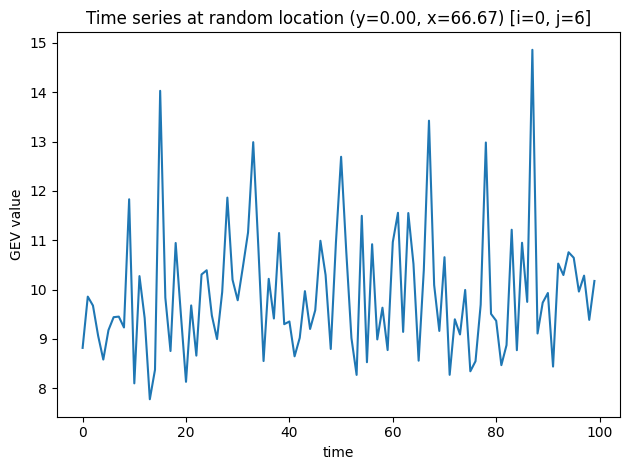

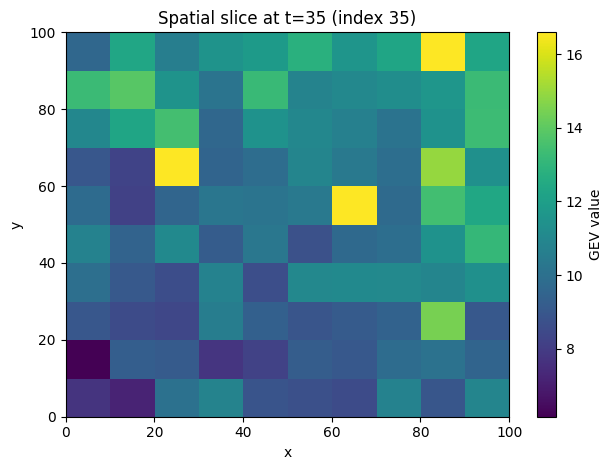

In [2]:
data, meta = generate_gev_dataset(n_lat=10, n_lon=10, n_time=100,beta_mu_t=0.18)
plot_random_time_series(data, meta)
plot_random_spatial_slice(data, meta)

In [3]:
from joblib import Parallel, delayed
def _build_exog_time_only(t_curve):
    X = np.asarray(t_curve, float)[:, None]
    return {"location": X, "scale": None, "shape": None}

def _fit_one(y_t, t_curve, optim_method="L-BFGS-B"):
    try:
        model = GEV(endog=y_t, exog=_build_exog_time_only(t_curve))
        fit = model.fit(optim_method=optim_method, fit_method="MLE")
        iL, iS, iX = model.len_exog
        p = fit.fitted_params
        return True, (iL, iS, iX), p, float(fit.n_ll)
    except Exception as e:
        return False, None, repr(e), np.nan

n_time, n_lat, n_lon = data.shape
jobs = [data[:, i, j].astype(float) for i in range(n_lat) for j in range(n_lon)]
res  = Parallel(n_jobs=-1, backend="loky", verbose=5)(delayed(_fit_one)(y, meta["t_curve"]) for y in jobs)

# unpack to rasters
ok_any = next((r for r in res if r[0]), None)
assert ok_any, "All fits failed."
iL, iS, iX = ok_any[1]
loc_coef = np.full((n_lat, n_lon, iL), np.nan); sca_coef = np.full((n_lat, n_lon, iS), np.nan); xi_coef = np.full((n_lat, n_lon, iX), np.nan)
nll = np.full((n_lat, n_lon), np.nan); ok_mask = np.zeros((n_lat, n_lon), bool)

k = 0
for i in range(n_lat):
    for j in range(n_lon):
        ok, sizes, payload, nll_ij = res[k]; k += 1
        if ok:
            p = payload
            loc_coef[i, j, :] = p[:iL]
            sca_coef[i, j, :] = p[iL:iL+iS]
            xi_coef[i, j, :]  = p[iL+iS:iL+iS+iX]
            nll[i, j] = nll_ij; ok_mask[i, j] = True
        else:
            # payload is error string; you can log if desired
            pass

print("Success ratio:", ok_mask.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  82 out of 100 | elapsed:  1.3min remaining:   16.5s


Success ratio: 1.0


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


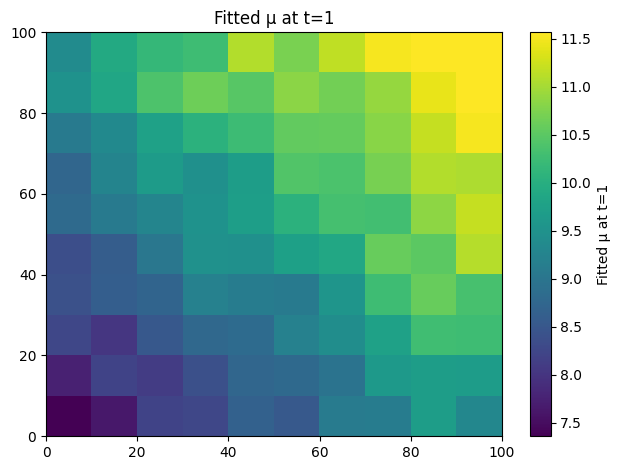

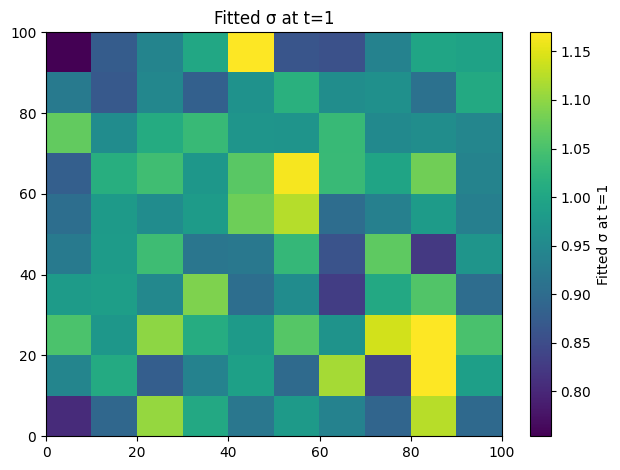

In [4]:
def plot_map(field, title, extent=None):
    vmax = float(np.quantile(field[np.isfinite(field)], 0.98))
    plt.figure(); im = plt.imshow(field, origin="lower", extent=extent, aspect="auto", interpolation="none", vmax=vmax)
    plt.colorbar(im, label=title)
    plt.title(title); plt.tight_layout(); plt.show()

rng = np.random.default_rng(123)
k = int(rng.integers(0, n_time)); t_k = float(meta["t_curve"][k])
mu_hat = loc_coef[:, :, 0] + (loc_coef[:, :, 1] if loc_coef.shape[2] > 1 else 0.0) * t_k
sig_hat = sca_coef[:, :, 0] + (sca_coef[:, :, 1] if sca_coef.shape[2] > 1 else 0.0) * t_k
extent = (meta["x"].min(), meta["x"].max(), meta["y"].min(), meta["y"].max())
plot_map(mu_hat,  f"Fitted μ at t={k}", extent)
plot_map(sig_hat, f"Fitted σ at t={k}", extent)

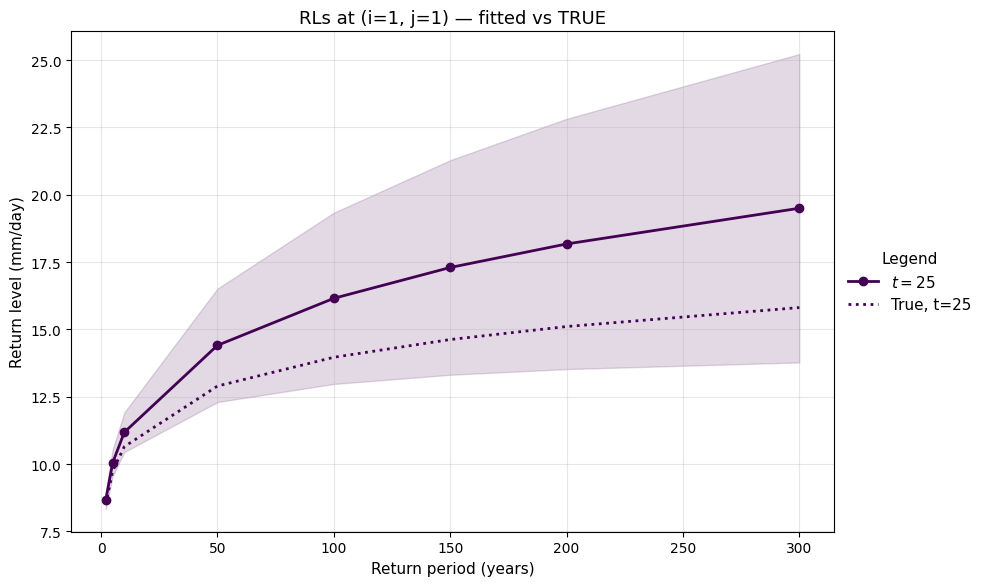


          EVT Results Summary       
Data dimensions : (100, 1)
AIC: 11.42  (AIC and BIC are based on MLE estimation)
BIC: 21.84  

+------------+--------------+--------------+--------------+---------------------------+----------+
| Parameter  | Estimate     | Deviance     | P>|Deviance| | 95% CI                    | Signif   |
+------------+--------------+--------------+--------------+---------------------------+----------+
| μ_0        | 8.3276       | 66.27        | 0.0000       | (8.0813, 8.5739)          | ***      |
| μ_1        | 0.0676       | 1.02         | 0.3099       | (-0.0628, 0.1979)         |          |
| σ_0        | 1.0073       | 11.14        | 0.0000       | (0.8300, 1.1846)          | ***      |
| ξ_0        | 0.2136       | 2.70         | 0.0069       | (0.0587, 0.3685)          | **       |
+------------+--------------+--------------+--------------+---------------------------+----------+
Significance : *** p<0.001, ** p<0.01, * p<0.05



c:\github\EVT_Univariate\EVT_Classes\GEV.py:1120: UserWarning: AIC is based on MLE estimation, not on 'MLE_JAX'.
  warnings.warn(f"AIC is based on MLE estimation, not on '{self.fit_method}'.", UserWarning)
c:\github\EVT_Univariate\EVT_Classes\GEV.py:1125: UserWarning: BIC is based on MLE estimation, not on 'MLE_JAX'.
  warnings.warn(f"BIC is based on MLE estimation, not on '{self.fit_method}'.", UserWarning)


In [5]:
# choose pixel and refit to get a GEVFit object
i = 1; j = 1
y_t = data[:, i, j].astype(float)
exog_time_only = {"location": meta["t_curve"][:, None], "scale": None, "shape": None}
fit_ij = GEV(endog=y_t, exog=exog_time_only)._fit_mle_jax()

T_list = [2,5,10,50,100,150,200,300]
t_list = [25]

# true params at those times
mu_true, sigma_true = meta["mu"], meta["sigma"]
def _xi_at(meta, t=None, i=None, j=None):
    xi = meta.get("xi", 0.0)
    if np.isscalar(xi): return float(xi)
    arr = np.asarray(xi)
    if arr.ndim == 0: return float(arr)
    if arr.ndim == 1 and t is not None: return float(arr[t])
    if arr.ndim == 3: return float(arr[t, i, j])
    return float(arr.ravel()[0])

manual_params = np.array([[float(mu_true[t, i, j]), float(sigma_true[t, i, j]), _xi_at(meta, t=t, i=i, j=j)] for t in t_list])
fit_ij.plot_return_levels(T=T_list, t=t_list, s=0, show_ci=True, manual_params=manual_params,
                          title=f"RLs at (i={i}, j={j}) — fitted vs TRUE")
print(fit_ij)


In [36]:

import numpy as np
from sklearn.model_selection import train_test_split

def coef_fields_to_params(loc_coef, sca_coef, xi_coef, t_curve):
    """
    Build μ̂, σ̂, ξ̂ from coefficient rasters and the time covariate t'(t).
    Assumes identity link for σ (your current setup).
    """
    t_curve = np.asarray(t_curve, dtype=np.float32)
    T = t_curve.shape[0]
    H, W, Lmu = loc_coef.shape
    Lsg = sca_coef.shape[2]

    mu0    = loc_coef[:, :, 0]
    betaMu = loc_coef[:, :, 1] if Lmu > 1 else 0.0

    s0     = sca_coef[:, :, 0]
    betaS  = sca_coef[:, :, 1] if Lsg > 1 else 0.0

    mu_hat  = np.empty((T, H, W), dtype=np.float32)
    sig_hat = np.empty_like(mu_hat)
    for k in range(T):
        mu_hat[k]  = mu0  + betaMu * t_curve[k]
        sig_hat[k] = s0   + betaS  * t_curve[k]

    # ξ̂ is time-constant per pixel for this fit; broadcast over time
    xi_grid = xi_coef[:, :, 0].astype(np.float32)
    xi_hat  = np.broadcast_to(xi_grid[None, :, :], (T, H, W)).copy()

    # safety
    sig_hat = np.maximum(sig_hat, 1e-6)
    return mu_hat, sig_hat, xi_hat

# 2) Build fitted parameter fields from your coefficients
mu_hat, sig_hat, xi_hat = coef_fields_to_params(loc_coef, sca_coef, xi_coef, meta["t_curve"])

# 3) Flatten over (t,i,j)
def flatten3(a3): return a3.reshape(-1).astype(np.float32)

y_flat        = flatten3(data)      # observed
mu_hat_flat   = flatten3(mu_hat)
sig_hat_flat  = flatten3(sig_hat)
xi_hat_flat   = flatten3(xi_hat)

# 4) Simple random split (80/10/10)
idx_all = np.arange(y_flat.shape[0])
idx_tr, idx_tmp = train_test_split(idx_all, test_size=0.20, random_state=42, shuffle=True)
idx_val, idx_te = train_test_split(idx_tmp, test_size=0.50, random_state=42, shuffle=True)

# 5) Build arrays for the network
#    - query “locations” for distances = μ̂
#    - teachers = fitted params (consistent with your earlier RL usage)
mu_query_tr   = mu_hat_flat[idx_tr]
mu_query_val  = mu_hat_flat[idx_val]
mu_query_te   = mu_hat_flat[idx_te]

mu_teacher_tr     = mu_hat_flat[idx_tr]
sigma_teacher_tr  = sig_hat_flat[idx_tr]
xi_teacher_tr     = xi_hat_flat[idx_tr]
y_tr              = y_flat[idx_tr]

mu_teacher_val    = mu_hat_flat[idx_val]
sigma_teacher_val = sig_hat_flat[idx_val]
xi_teacher_val    = xi_hat_flat[idx_val]
y_val             = y_flat[idx_val]

mu_teacher_te     = mu_hat_flat[idx_te]
sigma_teacher_te  = sig_hat_flat[idx_te]
xi_teacher_te     = xi_hat_flat[idx_te]
y_te              = y_flat[idx_te]

In [50]:
# ============================ μ, logσ, ξ 3-feature kernel + Gumbel7-NLL + ESS ============================
import numpy as np
import torch
import torch.nn as tnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[PyTorch] device: {device}")

# ---------- helpers: sampling, distances, ESS ----------
EPS = 1e-8

@torch.inference_mode()
def estimate_global_dist_scale(locs: torch.Tensor, num_pairs: int = 200_000) -> torch.Tensor:
    """Robust scale for pairwise distances: median over a random subset of pairs. locs: (N,D)"""
    N = locs.shape[0]
    if N < 2:
        return torch.tensor(1.0, device=locs.device)
    M = min(num_pairs, max(1, N*(N-1)))
    i = torch.randint(0, N, (M,), device=locs.device)
    j = torch.randint(0, N-1, (M,), device=locs.device)
    j = j + (j >= i).long()  # skip-self trick
    d = torch.linalg.norm(locs[i] - locs[j], dim=-1)
    return torch.median(d)

def sample_uniform_partners(batch_query_idx: torch.Tensor, K: int, N: int) -> torch.Tensor:
    B = batch_query_idx.shape[0]
    partners = torch.empty((B, K), dtype=torch.long, device=batch_query_idx.device)
    for b in range(B):
        q = int(batch_query_idx[b].item())
        idx = torch.randperm(N - 1, device=batch_query_idx.device)[:K]
        partners[b] = idx + (idx >= q)
    return partners

def rowwise_dists(locs: torch.Tensor, query_idx: torch.Tensor, partner_idx: torch.Tensor) -> torch.Tensor:
    """||loc[q]-loc[i]|| for each (q,i). locs: (N,D), q: (B,), i: (B,K) -> (B,K)"""
    qloc = locs.index_select(0, query_idx).unsqueeze(1)  # (B,1,D)
    ploc = locs.index_select(0, partner_idx.view(-1)).view(partner_idx.shape + (locs.shape[1],))  # (B,K,D)
    return torch.linalg.norm(ploc - qloc, dim=-1)        # (B,K)

@torch.inference_mode()
def ess_rows_from_raw(W: torch.Tensor) -> torch.Tensor:
    row_sum = torch.sum(W, dim=1) + EPS
    return (row_sum * row_sum) / (torch.sum(W * W, dim=1) + EPS)

# ---------- Gumbel (ξ=0) NLL ----------
# ---------- GEV NLL (stable, with ξ→0 branch) ----------
def query_weighted_gev_nll_loss(W_raw: torch.Tensor,
                              mu_n: torch.Tensor,
                              sigma_n: torch.Tensor,
                              xi_n: torch.Tensor,
                              y_q: torch.Tensor,
                              *,
                              sigma_min: float = 1e-6,
                              xi_eps: float = 1e-6,
                              t_min: float = 1e-9,
                              exp_clip: float = 50.0) -> torch.Tensor:
  """
  Row-normalize W_raw to W, then compute mean over queries of weighted GEV NLL.
  Shapes:
    W_raw, mu_n, sigma_n, xi_n : (B,K)
    y_q : (B,)
  """
  B, K = W_raw.shape
  W = rowsum_normalize(W_raw)     # (B,K)
  y  = y_q.view(B, 1)             # (B,1)

  beta = sigma_n.clamp_min(sigma_min)    # (B,K)
  xi   = xi_n                             # (B,K)

  # Masks for the ξ→0 limit
  small_xi = xi.abs() < xi_eps
  large_xi = ~small_xi

  # ----- Gumbel branch (ξ≈0) -----
  z = (y - mu_n) / beta
  nll_gumbel = torch.log(beta) + z + torch.exp(torch.clamp(-z, max=exp_clip))

  # ----- General GEV branch (ξ≠0) -----
  t = 1.0 + xi * (y - mu_n) / beta              # t must be > 0
  t_clamped = torch.clamp(t, min=t_min)
  log_t = torch.log(t_clamped)
  inv_xi = 1.0 / xi

  # t^{-1/xi} = exp( - (1/xi) * log t )
  pow_term = torch.exp(torch.clamp(-inv_xi * log_t, min=-exp_clip, max=exp_clip))
  nll_gev  = torch.log(beta) + (1.0 + inv_xi) * log_t + pow_term

  # Select per pair
  nll = torch.where(small_xi, nll_gumbel, nll_gev)  # (B,K)

  # Weighted per-query average, then mean over queries
  return (W * nll).sum(dim=1).mean()


def rowsum_normalize(W: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    return W / (W.sum(dim=1, keepdim=True).clamp_min(eps))

# ---------- tiny kernel net (now takes 3 features) ----------
class DynamicWeightNet(tnn.Module):
    """Input: (B,3) features [d_μ, d_logσ, d_ξ] -> Output: (B,1) weight in (0,1)."""
    def __init__(self, in_dim=3, hidden_dims=(32, 16), bias_init=0.8):
        super().__init__()
        layers, last = [], in_dim
        for h in hidden_dims:
            layers += [tnn.Linear(last, h), tnn.ReLU()]
            last = h
        self.backbone = tnn.Sequential(*layers)
        self.out = tnn.Linear(last, 1)
        with torch.no_grad():
            self.out.bias.fill_(bias_init)  # sigmoid(0.8) ~ 0.69

    def forward(self, x):  # x: (B,3)
        return torch.sigmoid(self.out(self.backbone(x)))

# ============================ tensors from your arrays ============================
# expects: mu_query_tr, y_tr, mu_teacher_tr, sigma_teacher_tr, xi_teacher_tr  (NumPy arrays)

locs_train_t    = torch.from_numpy(mu_query_tr.astype(np.float32)).to(device).unsqueeze(1)  # (N,1) for μ
y_train_t       = torch.from_numpy(y_tr.astype(np.float32)).to(device)
mu_teacher_t    = torch.from_numpy(mu_teacher_tr.astype(np.float32)).to(device)
sigma_teacher_t = torch.from_numpy(sigma_teacher_tr.astype(np.float32)).to(device)
xi_train_t      = torch.from_numpy(xi_teacher_tr.astype(np.float32)).to(device)             # (N,)

# --- log-σ for the second feature ---
log_sigma_train_t = torch.log(sigma_teacher_t.clamp_min(1e-12))                              # (N,)

# robust scales (train only)
with torch.inference_mode():
    mu_scale     = estimate_global_dist_scale(locs_train_t)                   # median |Δμ|
    logsig_scale = estimate_global_dist_scale(log_sigma_train_t.view(-1,1))   # median |Δlogσ|
    xi_scale     = estimate_global_dist_scale(xi_train_t.view(-1,1))          # median |Δξ|
print(f"[scales] med |Δμ|={float(mu_scale):.6f} | med |Δlogσ|={float(logsig_scale):.6f} | med |Δξ|={float(xi_scale):.6f}")

# ============================ training with ESS-based early stop ============================
K_SAMPLES         = 1000
epochs            = 500
batch_size        = 206
lr                = 1e-4
patience          = 300
ESS_MIN_THRESHOLD = 10
ESS_SAMPLE_SIZE   = 250

net   = DynamicWeightNet(in_dim=3).to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)

N = locs_train_t.shape[0]
best_train_loss = float('inf')
best_state = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}
patience_counter = 0

def _build_features(q_idx, i_idx):
    """
    Returns X: (B*K, 3) with columns:
      d_μ       = ((Δμ)^2)        / med(|Δμ|)^2
      d_logσ    = ((Δlogσ)^2)     / med(|Δlogσ|)^2
      d_ξ       = ((Δξ)^2)        / med(|Δξ|)^2
    """
    # μ feature
    d_mu = rowwise_dists(locs_train_t, q_idx, i_idx)                              # (B,K)
    f_mu = (d_mu ** 2) / ((mu_scale ** 2) + 1e-8)

    # logσ feature
    logsig_q = log_sigma_train_t.index_select(0, q_idx).unsqueeze(1)              # (B,1)
    logsig_i = log_sigma_train_t.index_select(0, i_idx.view(-1)).view_as(f_mu)    # (B,K)
    d_lsig   = torch.abs(logsig_i - logsig_q)
    f_lsig   = (d_lsig ** 2) / ((logsig_scale ** 2) + 1e-8)

    # ξ feature
    xi_q = xi_train_t.index_select(0, q_idx).unsqueeze(1)                          # (B,1)
    xi_i = xi_train_t.index_select(0, i_idx.view(-1)).view_as(f_mu)                # (B,K)
    d_xi = torch.abs(xi_i - xi_q)
    f_xi = (d_xi ** 2) / ((xi_scale ** 2) + 1e-8)

    X = torch.stack([f_mu, f_lsig, f_xi], dim=-1).reshape(-1, 3)                   # (B*K,3)
    return X, f_mu.shape  # shape is (B,K)

print(f"\nTraining 3-feature kernel with ESS early stop (threshold={ESS_MIN_THRESHOLD})...")
for epoch in range(1, epochs+1):
    net.train()
    prev_state_epoch = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}  # for ESS revert

    perm = torch.randperm(N, device=device)
    epoch_loss, num_batches = 0.0, int(np.ceil(N / batch_size))

    for b in range(num_batches):
        s, e = b*batch_size, min((b+1)*batch_size, N)
        if s >= e: continue

        q_idx = perm[s:e]                                        # (B,)
        yq    = y_train_t.index_select(0, q_idx)                 # (B,)
        i_idx = sample_uniform_partners(q_idx, K_SAMPLES, N)     # (B,K)

        # ----- build 3-feature inputs -----
        X, bk_shape = _build_features(q_idx, i_idx)              # X: (B*K,3), bk_shape=(B,K)

        # teacher params for partners
        mu_b    = mu_teacher_t.index_select(0, i_idx.view(-1)).view(bk_shape)
        sigma_b = sigma_teacher_t.index_select(0, i_idx.view(-1)).view(bk_shape)

        # weights
        W_raw = net(X).view(bk_shape)                            # (B,K)

        # Gumbel NLL (ξ=0) — loss unchanged
        loss = query_weighted_gumbel_nll_loss(W_raw, mu_b, sigma_b, yq)

        optim.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optim.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / max(1, num_batches)

    # --------- ESS early stop (raw weights, no masking) ---------
    net.eval()
    with torch.no_grad():
        M = int(min(ESS_SAMPLE_SIZE, N))
        sample_q = torch.randperm(N, device=device)[:M]                 # (M,)
        sample_i = sample_uniform_partners(sample_q, K_SAMPLES, N)      # (M,K)
        Xs, mk_shape = _build_features(sample_q, sample_i)              # (M*K,3), (M,K)
        W_s = net(Xs).view(mk_shape)                                    # (M,K)
        mean_ess = float(torch.mean(ess_rows_from_raw(W_s)).item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | train NLL: {avg_train_loss:.6f} | mean ESS ≈ {mean_ess:.1f}")

    if mean_ess < ESS_MIN_THRESHOLD or epoch==50:
        print(f"\n!!! Early stopping: mean ESS {mean_ess:.1f} < threshold {ESS_MIN_THRESHOLD:.1f}. "
              f"Reverting to previous epoch state. !!!")
        net.load_state_dict(prev_state_epoch)
        best_state = prev_state_epoch
        break

    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_state = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Training stopped early at epoch {epoch}.")
            break

# restore best
net.load_state_dict(best_state)
print(f"Final best train NLL: {best_train_loss:.6f}")
# =====================================================================================================


[PyTorch] device: cpu
[scales] med |Δμ|=1.006417 | med |Δlogσ|=0.079981 | med |Δξ|=0.079443

Training 3-feature kernel with ESS early stop (threshold=10)...
Epoch 010 | train NLL: 3.007310 | mean ESS ≈ 954.2
Epoch 020 | train NLL: 2.421110 | mean ESS ≈ 842.1
Epoch 030 | train NLL: 2.015931 | mean ESS ≈ 637.6
Epoch 040 | train NLL: 1.827001 | mean ESS ≈ 460.9
Epoch 050 | train NLL: 1.756565 | mean ESS ≈ 345.1

!!! Early stopping: mean ESS 345.1 < threshold 10.0. Reverting to previous epoch state. !!!
Final best train NLL: 1.762060


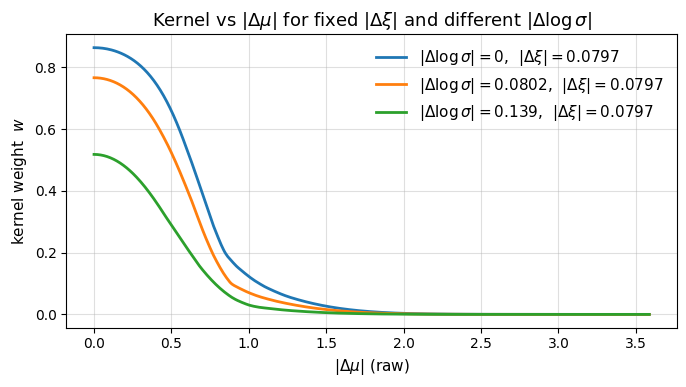

In [51]:
@torch.inference_mode()
def plot_kernel_vs_mu_distance(dynamic_net,
                               locs_train_t,                 # (N,1) for μ
                               mu_dist_scale,                # scalar tensor (median |Δμ|)
                               log_sigma_train_t,            # (N,)  log σ per item
                               logsig_dist_scale=None,       # scalar tensor (median |Δlogσ|); auto if None
                               xi_train_t=None,              # (N,)  ξ per item (optional but recommended)
                               xi_dist_scale=None,           # scalar tensor (median |Δξ|); auto if needed
                               *,
                               fixed_dxi="median",           # 0.0 | "median" | "p90" | float (raw |Δξ|)
                               squared: bool = True,
                               num_pairs: int = 200_000,
                               delta_logsig_vals="auto"      # "auto" -> [0, median, p90] or list of raw values
                               ):
    """
    Plots w(|Δμ|) for a 3-feature kernel [d_μ, d_logσ, d_ξ], with |Δξ| fixed.

    Features match training:
      d_μ       = ((Δμ)^2)        / med(|Δμ|)^2        if squared else (Δμ) / med(|Δμ|)
      d_logσ    = ((Δlogσ)^2)     / med(|Δlogσ|)^2     if squared else |Δlogσ| / med(|Δlogσ|)
      d_ξ       = ((Δξ)^2)        / med(|Δξ|)^2        if squared else |Δξ| / med(|Δξ|)
    """
    dynamic_net.eval()
    device = locs_train_t.device
    N = locs_train_t.shape[0]

    # ---- sample pairs to set sensible ranges and stats ----
    M = min(num_pairs, max(1, N*(N-1)))
    i = torch.randint(0, N, (M,), device=device)
    j = torch.randint(0, N-1, (M,), device=device); j = j + (j >= i).long()

    dmu_raw = torch.linalg.norm(locs_train_t[i] - locs_train_t[j], dim=-1)   # |Δμ|
    dls_raw = torch.abs(log_sigma_train_t[i] - log_sigma_train_t[j])         # |Δlogσ|

    # ranges for μ
    dmax = float(torch.quantile(dmu_raw, 0.99).item())
    dgrid = torch.linspace(0.0, dmax, steps=512, device=device)              # raw |Δμ| grid

    # μ feature along grid (match training)
    if squared:
        f_mu = (dgrid ** 2) / ((mu_dist_scale ** 2) + 1e-8)
    else:
        f_mu = dgrid / (mu_dist_scale + 1e-8)

    # scales for logsigma / xi if needed
    if logsig_dist_scale is None:
        logsig_dist_scale = estimate_global_dist_scale(log_sigma_train_t.view(-1,1))

    # resolve fixed |Δξ|
    if isinstance(fixed_dxi, str):
        key = fixed_dxi.lower()
        if xi_train_t is None and key != "0" and key != "zero":
            raise ValueError("xi_train_t must be provided unless fixed_dxi is 0.0")
        if key == "median":
            dxi_raw = torch.abs(xi_train_t[i] - xi_train_t[j]) if xi_train_t is not None else None
            fixed_xi_raw = float(torch.quantile(dxi_raw, 0.50).item()) if dxi_raw is not None else 0.0
        elif key in ("p90", "90", "0.9"):
            dxi_raw = torch.abs(xi_train_t[i] - xi_train_t[j]) if xi_train_t is not None else None
            fixed_xi_raw = float(torch.quantile(dxi_raw, 0.90).item()) if dxi_raw is not None else 0.0
        elif key in ("0", "zero"):
            fixed_xi_raw = 0.0
        else:
            raise ValueError(f"Unrecognized fixed_dxi spec: {fixed_dxi}")
    else:
        fixed_xi_raw = float(fixed_dxi)

    if abs(fixed_xi_raw) > 0 and xi_dist_scale is None:
        if xi_train_t is None:
            raise ValueError("xi_train_t required to auto-compute xi_dist_scale.")
        xi_dist_scale = estimate_global_dist_scale(xi_train_t.view(-1,1))

    # build constant ξ feature along the μ grid
    if abs(fixed_xi_raw) == 0:
        f_xi = torch.zeros_like(f_mu)
    else:
        if squared:
            fxi_scalar = (fixed_xi_raw ** 2) / ((xi_dist_scale ** 2) + 1e-8)
        else:
            fxi_scalar = fixed_xi_raw / (xi_dist_scale + 1e-8)
        f_xi = torch.full_like(f_mu, fxi_scalar)

    # choose |Δlogσ| slices
    if isinstance(delta_logsig_vals, str) and delta_logsig_vals.lower() == "auto":
        med_dls = float(torch.quantile(dls_raw, 0.50).item())
        p90_dls = float(torch.quantile(dls_raw, 0.75).item())
        slices = [0.0, med_dls, p90_dls]
    elif delta_logsig_vals is None:
        slices = [0.0]
    else:
        slices = list(delta_logsig_vals)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,4))
    x_np = dgrid.detach().cpu().numpy()

    for dls in slices:
        dls = float(abs(dls))
        # σ feature (constant along μ grid), same transform as training
        if squared:
            fsig_scalar = (dls ** 2) / ((logsig_dist_scale ** 2) + 1e-8)
        else:
            fsig_scalar = dls / (logsig_dist_scale + 1e-8)
        f_sig = torch.full_like(f_mu, fsig_scalar)

        # assemble inputs in model order: [d_μ, d_logσ, d_ξ]
        X = torch.stack([f_mu, f_sig, f_xi], dim=-1)    # (512, 3)
        w = dynamic_net(X).squeeze(1).detach().cpu().numpy()

        plt.plot(x_np, w, lw=2,
                 label=rf'$|\Delta \log \sigma|={dls:.3g}$,  $|\Delta \xi|={fixed_xi_raw:.3g}$')

    plt.xlabel(r'$|\Delta \mu|$ (raw)')
    plt.ylabel(r'kernel weight  $w$')
    title = r'Kernel vs $|\Delta \mu|$ for fixed $|\Delta \xi|$ and different $|\Delta \log \sigma|$'
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Build the auxiliaries once:
log_sigma_train_t = torch.log(sigma_teacher_t.clamp_min(1e-12))  # (N,)
# If you kept the old name:
dist_scale = mu_scale  # alias

plot_kernel_vs_mu_distance(
    net,
    locs_train_t,
    dist_scale,                 # = mu_scale
    log_sigma_train_t,          # required (for |Δlogσ| slices)
    logsig_dist_scale=None,     # auto
    xi_train_t=xi_train_t,      # required to fix nonzero |Δξ|
    xi_dist_scale=None,         # auto if needed
    fixed_dxi="median",         # fix |Δξ| at dataset median; or 0.0, "p90", or a float
    squared=True,
    delta_logsig_vals="auto"    # curves at 0, median, 90th-percentile |Δlogσ|
)


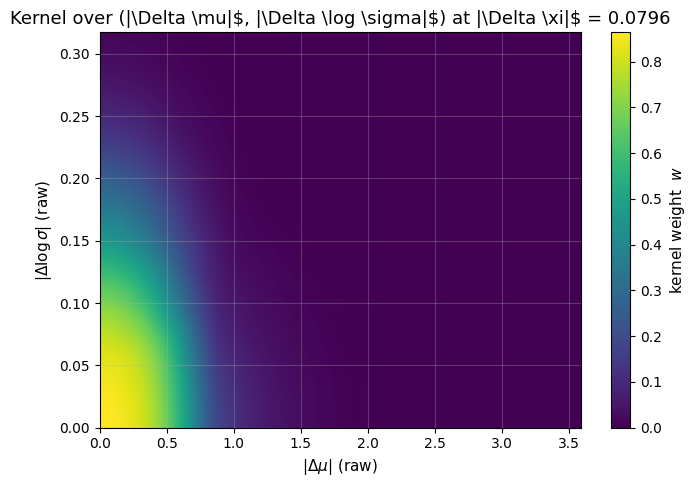

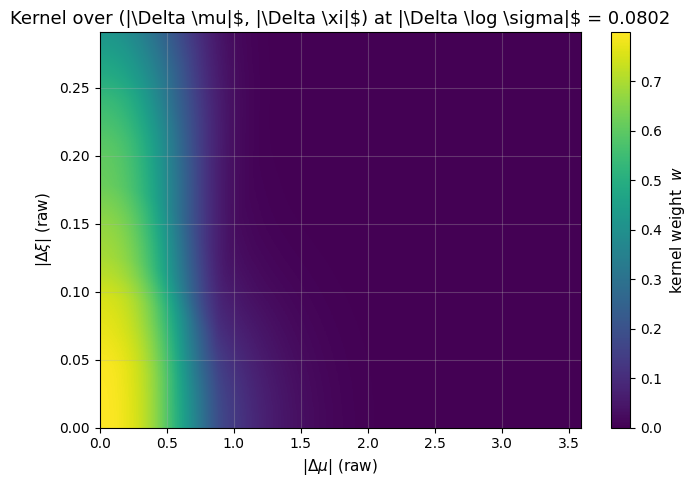

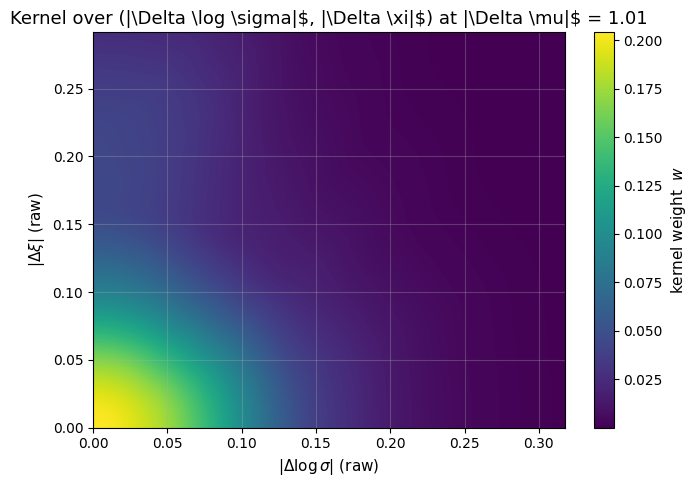

In [52]:
@torch.inference_mode()
def plot_kernel_heatmap(dynamic_net,
                        *,
                        # data tensors (provide the ones you need)
                        locs_train_t=None,           # (N,1)  for μ
                        log_sigma_train_t=None,      # (N,)   for logσ
                        xi_train_t=None,             # (N,)   for ξ
                        # robust scales (pass or will auto-compute from data)
                        mu_dist_scale=None,
                        logsig_dist_scale=None,
                        xi_dist_scale=None,
                        # which variables on axes / fixed:
                        x_axis: str = "mu",          # one of {"mu","logsigma","xi"}
                        y_axis: str = "xi",          # one of {"mu","logsigma","xi"}
                        fixed: dict | None = None,   # e.g. {"logsigma": "median"} or {"mu": 0.0}
                        # viz/transform
                        squared: bool = True,
                        num_pairs: int = 200_000,
                        nx: int = 200,
                        ny: int = 200):
    """
    General heatmap for the 3-feature kernel [d_μ, d_logσ, d_ξ].
    - Varies x_axis and y_axis over raw deltas (99th percentile ranges from data).
    - Holds the remaining variable at a fixed raw delta: float, 0.0, "median", or "p90".
    - Transforms to features exactly like training (squared + robust scaling, or linear if squared=False).
    """
    dynamic_net.eval()

    # ---- helpers ----
    def _need(name):
        if name == "mu" and locs_train_t is None:
            raise ValueError("locs_train_t required for 'mu'.")
        if name == "logsigma" and log_sigma_train_t is None:
            raise ValueError("log_sigma_train_t required for 'logsigma'.")
        if name == "xi" and xi_train_t is None:
            raise ValueError("xi_train_t required for 'xi'.")

    def _device():
        for t in (locs_train_t, log_sigma_train_t, xi_train_t):
            if t is not None:
                return t.device
        return next(dynamic_net.parameters()).device

    def _sample_pairs(N):
        M = min(num_pairs, max(1, N*(N-1)))
        i = torch.randint(0, N, (M,), device=device)
        j = torch.randint(0, N-1, (M,), device=device)
        j = j + (j >= i).long()
        return i, j

    def _raw_delta(name, i, j):
        if name == "mu":
            return torch.linalg.norm(locs_train_t[i] - locs_train_t[j], dim=-1)
        elif name == "logsigma":
            return torch.abs(log_sigma_train_t[i] - log_sigma_train_t[j])
        elif name == "xi":
            return torch.abs(xi_train_t[i] - xi_train_t[j])
        else:
            raise ValueError(f"Unknown var '{name}'")

    def _scale_of(name):
        nonlocal mu_dist_scale, logsig_dist_scale, xi_dist_scale
        if name == "mu":
            if mu_dist_scale is None:
                mu_dist_scale = estimate_global_dist_scale(locs_train_t)
            return mu_dist_scale
        if name == "logsigma":
            if logsig_dist_scale is None:
                logsig_dist_scale = estimate_global_dist_scale(log_sigma_train_t.view(-1,1))
            return logsig_dist_scale
        if name == "xi":
            if xi_dist_scale is None:
                xi_dist_scale = estimate_global_dist_scale(xi_train_t.view(-1,1))
            return xi_dist_scale

    def _to_feature(name, raw):
        s = _scale_of(name)
        if squared:
            return (raw ** 2) / ((s ** 2) + 1e-8)
        else:
            return raw / (s + 1e-8)

    def _axis_grid(name, max_raw, steps):
        g = torch.linspace(0.0, max_raw, steps=steps, device=device)
        return g

    def _resolve_fixed(name, i, j):
        if fixed is None or name not in fixed:
            # default: use median if we can, else 0.0
            try:
                return float(torch.quantile(_raw_delta(name, i, j), 0.50).item())
            except Exception:
                return 0.0
        val = fixed[name]
        if isinstance(val, (int, float)):
            return float(val)
        key = str(val).lower()
        if key == "median":
            return float(torch.quantile(_raw_delta(name, i, j), 0.50).item())
        if key in ("p90", "90", "0.9"):
            return float(torch.quantile(_raw_delta(name, i, j), 0.90).item())
        if key in ("zero", "0"):
            return 0.0
        raise ValueError(f"Unrecognized fixed value spec: {val}")

    # ---- setup & validations ----
    x_axis = x_axis.lower()
    y_axis = y_axis.lower()
    axes = {"mu", "logsigma", "xi"}
    if x_axis not in axes or y_axis not in axes or x_axis == y_axis:
        raise ValueError("x_axis and y_axis must be distinct in {'mu','logsigma','xi'}")

    fixed_var = list(axes - {x_axis, y_axis})[0]
    _need(x_axis); _need(y_axis); _need(fixed_var)

    device = _device()
    # determine N from any provided tensor
    N = None
    for t in (locs_train_t, log_sigma_train_t, xi_train_t):
        if t is not None:
            N = t.shape[0]
            break
    if N is None:
        raise ValueError("No data tensors provided.")

    # sample for ranges & fixed raw
    i, j = _sample_pairs(N)
    x_raw = _raw_delta(x_axis, i, j)
    y_raw = _raw_delta(y_axis, i, j)
    x_max = float(torch.quantile(x_raw, 0.99).item())
    y_max = float(torch.quantile(y_raw, 0.99).item())
    fixed_raw = _resolve_fixed(fixed_var, i, j)

    # build axis grids in raw units
    gx = _axis_grid(x_axis, x_max, nx)   # (nx,)
    gy = _axis_grid(y_axis, y_max, ny)   # (ny,)
    GY, GX = torch.meshgrid(gy, gx, indexing='ij')  # (ny,nx)

    # convert to features in training space
    F_mu = torch.zeros_like(GX)
    F_sig = torch.zeros_like(GX)
    F_xi = torch.zeros_like(GX)

    # fill x & y
    if x_axis == "mu":       F_mu = _to_feature("mu", GX)
    if x_axis == "logsigma": F_sig = _to_feature("logsigma", GX)
    if x_axis == "xi":       F_xi = _to_feature("xi", GX)

    if y_axis == "mu":       F_mu = _to_feature("mu", GY) if F_mu.numel()==0 else _to_feature("mu", GY)
    if y_axis == "logsigma": F_sig = _to_feature("logsigma", GY)
    if y_axis == "xi":       F_xi = _to_feature("xi", GY)

    # set fixed var
    fixed_feat_scalar = _to_feature(fixed_var, torch.tensor(float(fixed_raw), device=device))
    if fixed_var == "mu":       F_mu = torch.full_like(GX, fixed_feat_scalar)
    if fixed_var == "logsigma": F_sig = torch.full_like(GX, fixed_feat_scalar)
    if fixed_var == "xi":       F_xi = torch.full_like(GX, fixed_feat_scalar)

    # assemble X in the model's expected order [d_mu, d_logσ, d_ξ]
    X = torch.stack([F_mu.reshape(-1), F_sig.reshape(-1), F_xi.reshape(-1)], dim=-1)  # (ny*nx,3)
    W = dynamic_net(X).reshape(ny, nx).detach().cpu().numpy()

    # labels
    axis_label = {
        "mu": r"$|\Delta \mu|$ (raw)",
        "logsigma": r"$|\Delta \log \sigma|$ (raw)",
        "xi": r"$|\Delta \xi|$ (raw)"
    }

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,5))
    extent = [0.0, x_max, 0.0, y_max]
    plt.imshow(W, origin='lower', aspect='auto', extent=extent)
    plt.colorbar(label='kernel weight  $w$')
    plt.xlabel(axis_label[x_axis])
    plt.ylabel(axis_label[y_axis])
    plt.title(rf"Kernel over ({axis_label[x_axis][1:-6]}, {axis_label[y_axis][1:-6]}) at "
              rf"{axis_label[fixed_var][1:-6]} = {fixed_raw:.3g}")
    plt.tight_layout()
    plt.show()
# prerequisites already in your script:
# locs_train_t, log_sigma_train_t = torch.log(sigma_teacher_t.clamp_min(1e-12)), xi_train_t
# mu_scale, logsig_scale, xi_scale computed earlier (or let the function auto-compute)


# 1) μ–ξ heatmap at median |Δlogσ|
plot_kernel_heatmap(
    net,
    locs_train_t=locs_train_t,
    log_sigma_train_t=log_sigma_train_t,
    xi_train_t=xi_train_t,
    mu_dist_scale=mu_scale,
    logsig_dist_scale=logsig_scale,
    xi_dist_scale=xi_scale,
    x_axis="mu", y_axis="logsigma",
    fixed={"logsigma": "median"},
    squared=True
)


# 1) μ–ξ heatmap at median |Δlogσ|
plot_kernel_heatmap(
    net,
    locs_train_t=locs_train_t,
    log_sigma_train_t=log_sigma_train_t,
    xi_train_t=xi_train_t,
    mu_dist_scale=mu_scale,
    logsig_dist_scale=logsig_scale,
    xi_dist_scale=xi_scale,
    x_axis="mu", y_axis="xi",
    fixed={"logsigma": "median"},
    squared=True
)

# 2) σ–ξ heatmap at median |Δμ|
plot_kernel_heatmap(
    net,
    locs_train_t=locs_train_t,
    log_sigma_train_t=log_sigma_train_t,
    xi_train_t=xi_train_t,
    mu_dist_scale=mu_scale,
    logsig_dist_scale=logsig_scale,
    xi_dist_scale=xi_scale,
    x_axis="logsigma", y_axis="xi",
    fixed={"mu": "median"},
    squared=True
)


In [40]:
from matplotlib.animation import FuncAnimation

# ---------- small helper ----------
def _extent_from_meta(meta):
    if meta is not None and "x" in meta and "y" in meta:
        x = np.asarray(meta["x"]); y = np.asarray(meta["y"])
        return (x.min(), x.max(), y.min(), y.max())
    return None

@torch.inference_mode()
def _weight_map_from_mu_frame(dynamic_net, mu_frame_np, mu_q_scalar, dist_scale,
                              squared: bool = True, device=None,
                              lat_stride: int = 1, lon_stride: int = 1,
                              roi: tuple | None = None,  # (i_start, i_end, j_start, j_end)
                              use_fp16: bool = False):
    """
    One frame: spatial weights at a fixed time given a query μ.
    Returns (H',W') numpy map after ROI+stride.
    """
    if device is None:
        device = next(dynamic_net.parameters()).device

    if roi is not None:
        i0, i1, j0, j1 = roi
        mu_frame_np = mu_frame_np[i0:i1, j0:j1]
    mu_frame_np = mu_frame_np[::lat_stride, ::lon_stride]

    dtype = torch.float16 if (use_fp16 and device.type == "cuda") else torch.float32
    mu_frame = torch.from_numpy(mu_frame_np.astype(np.float32)).to(device=device, dtype=dtype)
    mu_q = torch.tensor(float(mu_q_scalar), device=device, dtype=dtype)

    d = torch.abs(mu_frame - mu_q)             # |Δμ|
    if squared:
        d = (d ** 2) / ((dist_scale ** 2) + 1e-8)
    else:
        d = d / (dist_scale + 1e-8)

    W = dynamic_net(d.reshape(-1, 1)).reshape_as(mu_frame)
    return W.detach().float().cpu().numpy()


# ======================= 1) 1D plot — fixed (i0,j0), ref time moves =======================
@torch.inference_mode()
def animate_temporal_1d_for_pixel(dynamic_net, mu_hat, dist_scale,
                                  i0: int, j0: int,
                                  squared: bool = True,
                                  t_step: int = 1, max_frames: int | None = None,
                                  fps: int = 10, save_path: str | None = None):
    """
    For pixel (i0,j0), show weights vs *all times*; the reference time moves across frames.
    """
    dynamic_net.eval()
    device = next(dynamic_net.parameters()).device
    mu_line = mu_hat[:, i0, j0].astype(np.float32)  # (T,)
    T = mu_line.shape[0]

    t_list = list(range(0, T, t_step))
    if max_frames is not None:
        t_list = t_list[:max_frames]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xlim(0, T-1); ax.set_ylim(0, 1)
    ax.set_xlabel("time index"); ax.set_ylabel("kernel weight")
    ax.grid(True, alpha=0.3)
    title = ax.set_title("")
    line, = ax.plot([], [], lw=2)
    marker = ax.scatter([], [], c="red", s=80, zorder=5)

    # prebuild torch tensor holder to avoid realloc per frame
    x_torch = torch.empty((T, 1), device=device, dtype=torch.float32)

    def _weights_for_ref(t_ref: int):
        # distances across time against the reference μ at this pixel
        d = np.abs(mu_line - mu_line[t_ref])
        if squared:
            x = (d ** 2) / ((float(dist_scale) ** 2) + 1e-8)
        else:
            x = d / (float(dist_scale) + 1e-8)
        x_torch[:, 0] = torch.from_numpy(x.astype(np.float32)).to(device)
        w = dynamic_net(x_torch).squeeze(1).detach().cpu().numpy()
        return w

    def _update(fi):
        t_ref = t_list[fi]
        w = _weights_for_ref(t_ref)
        line.set_data(np.arange(T), w)
        marker.set_offsets([t_ref, w[t_ref]])
        title.set_text(f"Temporal weights at (i={i0}, j={j0}) — ref t={t_ref}")
        return line, marker, title

    anim = FuncAnimation(fig, _update, frames=len(t_list),
                         interval=int(1000/fps), blit=False)
    plt.close(fig)
    if save_path:
        anim.save(save_path, writer="pillow", fps=fps)
        print(f"saved temporal 1D animation → {save_path}")
    return anim


# ======================= 2) 2D plot — fixed t0, ref pixel moves in space =======================
@torch.inference_mode()
def animate_spatial_2d_for_time(dynamic_net, mu_hat, dist_scale,
                                t0: int,
                                meta=None,
                                squared: bool = True,
                                lat_stride: int = 1, lon_stride: int = 1,
                                roi: tuple | None = None,      # (i_start,i_end,j_start,j_end)
                                path: str = "scan",            # "scan" (serpentine) or "random"
                                max_frames: int | None = None,
                                fps: int = 10,
                                vmax_quantile: float = 0.99,
                                use_fp16: bool = False,
                                save_path: str | None = None):
    """
    At fixed time t0, move the reference pixel across space; each frame shows a spatial weight heatmap.
    """
    dynamic_net.eval()
    T, H, W = mu_hat.shape
    extent = _extent_from_meta(meta)

    # build traversal order over (i,j)
    if path == "random":
        order = np.column_stack([
            np.random.randint(0, H, size=H*W),
            np.random.randint(0, W, size=H*W)
        ])
    else:  # serpentine scan with strides
        order = []
        for i in range(0, H, lat_stride):
            cols = list(range(0, W, lon_stride)) if (i // lat_stride) % 2 == 0 \
                   else list(range(W-1, -1, -lon_stride))
            for j in cols:
                order.append((i, j))
        order = np.array(order, dtype=int)

    if max_frames is not None:
        order = order[:max_frames]

    # probe some frames to set a stable vmax
    probe_idx = np.linspace(0, len(order)-1, num=min(40, len(order)), dtype=int)
    probe_vals = []
    for idx in probe_idx:
        i, j = order[idx]
        mu_q = float(mu_hat[t0, i, j])
        w = _weight_map_from_mu_frame(dynamic_net, mu_hat[t0], mu_q, dist_scale,
                                      squared=squared, lat_stride=lat_stride, lon_stride=lon_stride,
                                      roi=roi, use_fp16=use_fp16)
        probe_vals.append(w)
    vmax = float(np.quantile(np.array(probe_vals).ravel(), vmax_quantile)) if probe_vals else 1.0

    # determine displayed shape after ROI+stride
    if roi is None:
        Hs, Ws = H, W
    else:
        Hs, Ws = roi[1]-roi[0], roi[3]-roi[2]
    Hs = (Hs + lat_stride - 1) // lat_stride
    Ws = (Ws + lon_stride - 1) // lon_stride

    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(np.zeros((Hs, Ws)), origin="lower", extent=extent, aspect="auto",
                   vmin=0, vmax=vmax, cmap="viridis", interpolation="none")
    fig.colorbar(im, ax=ax, label="kernel weight")
    ref_scatter = ax.scatter([], [], s=150, c="red", marker="*", edgecolor="black", zorder=5)
    title = ax.set_title("")

    def _update(fi):
        i, j = order[fi]
        mu_q = float(mu_hat[t0, i, j])
        w = _weight_map_from_mu_frame(dynamic_net, mu_hat[t0], mu_q, dist_scale,
                                      squared=squared, lat_stride=lat_stride, lon_stride=lon_stride,
                                      roi=roi, use_fp16=use_fp16)
        im.set_data(w)
        # update reference marker
        if extent is None:
            # image pixel coords (account for ROI/stride)
            ii = (i - (roi[0] if roi else 0)) // lat_stride
            jj = (j - (roi[2] if roi else 0)) // lon_stride
            ref_scatter.set_offsets([jj, ii])
        else:
            ref_scatter.set_offsets([float(meta["x"][j]), float(meta["y"][i])])
        title.set_text(f"Spatial weights — fixed t={t0}, ref=(i={i}, j={j})")
        return im, ref_scatter, title

    anim = FuncAnimation(fig, _update, frames=len(order),
                         interval=int(1000/fps), blit=False)
    plt.close(fig)
    if save_path:
        anim.save(save_path, writer="pillow", fps=fps)
        print(f"saved spatial 2D animation → {save_path}")
    return anim


In [32]:
# assumes:
#   net         ← trained DynamicWeightNet
#   mu_hat      ← fitted μ field, shape (T, H, W)
#   dist_scale  ← torch scalar (median |Δμ|) on the same device as net
#   meta        ← optional dict with 'x','y' for nice extents

# 1D temporal (ref time moves)
i0, j0 = 3, 5
anim_1d = animate_temporal_1d_for_pixel(
    net, mu_hat, dist_scale, i0, j0,
    squared=True, t_step=2, max_frames=80, fps=10,
    save_path="temporal_1d.gif"  # or "temporal_1d.gif"
)


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


IndexError: list index out of range

In [12]:
# 2D spatial (ref pixel moves) at fixed time
t0 = 35
anim_2d = animate_spatial_2d_for_time(
    net, mu_hat, dist_scale, t0,
    meta=meta,
    lat_stride=1, lon_stride=1,     # speed-up
    roi=None,                       # or (i_start,i_end,j_start,j_end)
    path="scan", max_frames=200, fps=2,
    save_path="spatial.gif"  # or "spatial_2d.gif"
)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


saved spatial 2D animation → spatial.gif


In [41]:
# ==== Weighted multi-series GEV fit (all pixels), weights from μ-distance kernel ====
import numpy as np
import torch
from GEV import GEV

# --- 0) pick the space–time reference point for the weights ---
t_ref, i_ref, j_ref = 25, 1, 1   # change as you like

# --- 1) choose which μ-field to use for distances ---
def get_mu_field():
    # Prefer fitted μ if you computed it (e.g., from loc_coef or model output)
    if 'mu_hat' in globals():
        mu = np.asarray(mu_hat, dtype=np.float32)     # (T,H,W)
        assert mu.ndim == 3
        return mu
    # Or reconstruct from pointwise coefficients (μ = μ0 + βμ,t * t')
    if 'loc_coef' in globals() and 'meta' in globals():
        lc = np.asarray(loc_coef, np.float32)         # (H,W,2): [μ0, βμ,t]
        t_curve = np.asarray(meta['t_curve'], np.float32)  # (T,)
        mu = lc[..., 0][None, :, :] + lc[..., 1][None, :, :] * t_curve[:, None, None]
        return mu.astype(np.float32)
    # Fallback to the generator's true μ
    return np.asarray(meta['mu'], dtype=np.float32)

mu_field = get_mu_field()              # (T,H,W)
T, H, W_ = mu_field.shape
assert data.shape[:3] == (T, H, W_)

# --- 2) compute μ-distance to the reference for every (t,i,j) ---
mu_ref = float(mu_field[t_ref, i_ref, j_ref])
d_mu   = np.abs(mu_field - mu_ref).astype(np.float32)    # (T,H,W)

# --- 3) turn μ-distance into the same feature the kernel was trained on ---
kernel = dynamic_net if 'dynamic_net' in globals() else net
device = next(kernel.parameters()).device
with torch.inference_mode():
    x = torch.from_numpy(d_mu).to(device=device, dtype=torch.float32)  # (T,H,W)
    # If you trained with squared/median-normalized distance, keep it:
    x = (x**2) / (dist_scale**2 + 1e-8)
    w = kernel(x.view(-1, 1)).squeeze(1)                 # (T*H*W,)
    W_mat = w.detach().cpu().numpy().reshape(T, H*W_)    # (n_obs, n_samples)

# (optional) tiny floor for numerical safety
W_mat = np.maximum(W_mat, 1e-12)

# --- 4) build multi-series endog and exog (time-only) ---
Y = data.reshape(T, H*W_).astype(float)                  # (n_obs, n_samples)
X_t = meta['t_curve']                                    # length T (1-D is fine)
exog_time_only = {"location": None, "scale": None, "shape": None}

# --- 5) fit the weighted GEV across all pixels at once ---
model_all = GEV(endog=Y, exog=exog_time_only, weights=W_mat)   # identity links by default
fit_all   = model_all._fit_mle_jax()
print(fit_all)

# --- 6) (optional) RL plot for a specific pixel from the multi-series fit ---
# choose which pixel to visualize (use the same (i,j) or any other)
i_vis, j_vis = i_ref, j_ref
s_idx = i_vis * W_ + j_vis     # flatten index consistent with reshape(T, H*W)

T_list = [1.1, 5, 10, 50, 100, 150, 200, 300, 500]
t_list = [t_ref]

def _xi_at(meta, t=None, i=None, j=None):
    xi = meta.get("xi", 0.0)
    if np.isscalar(xi): return float(xi)
    arr = np.asarray(xi)
    if arr.ndim == 0: return float(arr)
    if arr.ndim == 1 and t is not None: return float(arr[t])
    if arr.ndim == 3 and None not in (t,i,j): return float(arr[t, i, j])
    return float(arr.ravel()[0])

manual_params = np.array([
    [ float(meta["mu"][t, i_vis, j_vis]),
      float(meta["sigma"][t, i_vis, j_vis]),
      _xi_at(meta, t=t, i=i_vis, j=j_vis) ]
    for t in t_list
], dtype=float)

fit_all.plot_return_levels(
    T=T_list, t=t_list, s=s_idx, show_ci=True,
    manual_params=manual_params,
    title=f"Weighted ALL-pixels GEV — view (i={i_vis}, j={j_vis}) | ref=({t_ref},{i_ref},{j_ref})"
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x1 and 3x32)